#                            Stock Analysis and Price Prediction

# Contents
    1. Introduction
    2. Importing libraries
    3. Reading datasets
    4. Building Models
    5. Conclusion

# Introduction
In general, Stock analysis is an assessment of a specific trading instrument, an investment segment, or the entire economy. It is a way of making purchasing and selling decisions for investors and traders. Investors and traders seek to gain an advantage in the markets by making educated choices by analyzing and reviewing past and present results.

This project demonstrates the technique of machine learning called Long Short-Term Memory (LSTM) to forecast market prices and create portfoil optimization using Efficient Frontier. 

For this we will first evaluate the 20 different stocks and pick the top five higher return stocks that will be used to create a optimize portfoilo. Among them, one stock with a higher return and lower risk will be chosen to predict the future stock price.

We will be answering the following question:

1. What was the change in price of the stock over time?
2. What was the monthly return of the stock on average?
3. What was the moving average of the various stocks?
4. What was the correlation between different stocks'?
5. How much value do we put at risk by investing in a particular stock?
6. Portfoilo optimization using Efficient Frontier?
7. How can we attempt to predict future stock behavior using LSTM?

# Importing Libraries

Here are list of all the libraries that are need for this project.

In [1]:
# here we are importing important libraries
import math
import pandas_datareader as pdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco
import tensorflow as tf
import datetime
from termcolor import colored

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from pandas_datareader import data as web
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

plt.style.use("Solarize_Light2")
sns.set_style('whitegrid')
%matplotlib inline

# Reading Dataset

In order to carry out inventory analysis, we need historical asset data. There are several information providers, some of which are free, most of which are charged. For this project, we will be  using data from Yahoo's finance website since 2013. We can do this in Python with the pandas-datareader module.

Companies names and their aliases (Ticker) that are used through out our Analysis
    
    1. Apple Inc. = AAPL
    2. Alphabet Inc. = GOOG
    3. Microsoft Corporation = MSFT
    4. Amazon = AMZN
    5. Facebook Inc. = FB
    6. Alibaba Group = BABA
    7. Johnson & Johnson = JNJ
    8. JPMorgon Chase & Co. = JPM
    9. ExxonMobil = XOM
    10.Bank of America = BAC
    11.WalMart Store Inc. = WMT
    12.Wells Fargo & Co. = WFC
    13.Visa Inc. = V
    14.Procter & Gamble Co. = PG
    15.Verizon Communication = VZ
    16.AT&T Inc. = T
    17.UnitedHealth Group Inc. = UNH
    18.Home Depot = HD
    19.Intel = INTC
    20.Oracle = ORCL



In [2]:
#List of ticker of companies
ticker_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN', 'FB', 'BABA','JNJ', 'JPM', 'XOM', 'BAC', 'WMT', 'WFC', 'V', 'PG', 'VZ', 'T', 'UNH', 'HD', 'INTC', 'ORCL']

# Mapping of Ticker with companies names
CompanyNameMap={
    "AAPL":"Apple Inc",
    "GOOG":"Alphabet Inc",
    "MSFT":"Microsoft Corporation",
    "AMZN":"Amazon",
    "FB":"Facebook Inc",
    "BABA": "Alibaba Group",
    "JNJ":"Johnson & Johnson",
    "JPM":"JPMorgon Chase & Co",
    "XOM": "ExxonMobil",
    "BAC": "Bank of America",
    "WMT": "WalMart Store Inc",
    "WFC":"Wells Fargo & Co",
    "V": "Visa Inc",
    "PG": "Procter & Gamble Co",
    "VZ": "Verizon Communication",
    "T":"AT&T Inc",
    "UNH": "UnitedHealth Group Inc",
    "HD": "Home Depot",
    "INTC": "Intel",
    "ORCL":"Oracle"
}

In [3]:
# Downloading stocks data since 2013
data = pdr.get_data_yahoo(ticker_list, start = '2015-01-01')

# 1. What was the change in price of the stock over time?

We will start by looking at historical data and then conducting the return calculations to see how well each stock has done.

In [4]:
# Looking at the portion of historial data
data.tail()

Attributes   Adj Close                                                    \
Symbols           AAPL         GOOG        MSFT         AMZN          FB   
Date                                                                       
2020-11-25  116.029999  1771.430054  213.869995  3185.070068  275.589996   
2020-11-27  116.589996  1793.189941  215.229996  3195.340088  277.809998   
2020-11-30  119.050003  1760.739990  214.070007  3168.040039  276.970001   
2020-12-01  122.720001  1798.099976  216.210007  3220.080078  286.549988   
2020-12-02  123.080002  1827.949951  215.369995  3203.530029  287.519989   

Attributes                                                            ...  \
Symbols           BABA         JNJ         JPM        XOM        BAC  ...   
Date                                                                  ...   
2020-11-25  277.720001  143.679993  122.029999  40.810001  29.030001  ...   
2020-11-27  276.480011  144.000000  121.220001  40.189999  28.990000  ...   
2020-11-30  263.359985  144.679993  117.879997  38.130001  28.160000  ...   
2020-12-01  264.010010  147.449997  119.739998  38.500000  28.690001  ...   
2020-12-02  261.320007  148.139999  122.040001  39.939999  29.059999  ...   

Attributes      Volume                                                 \
Symbols            WMT         WFC          V          PG          VZ   
Date                                                                    
2020-11-25   4611100.0  38875500.0  6772900.0   8411300.0  10604300.0   
2020-11-27   3666500.0  20281400.0  3512900.0   4252200.0   5763700.0   
2020-11-30  10898500.0  48211000.0  7725500.0  11640400.0  21839100.0   
2020-12-01   7647100.0  42001800.0  8049400.0   7169700.0  14283200.0   
2020-12-02   7842600.0  35480700.0  9726800.0   6961900.0  14167500.0   

Attributes                                                            
Symbols              T        UNH         HD        INTC        ORCL  
Date                                                                  
2020-11-25  24489200.0  3145100.0  3001700.0  28126900.0   6848900.0  
2020-11-27  15649800.0  1558600.0  1625300.0  15921400.0   5627000.0  
2020-11-30  43340500.0  5265700.0  4624100.0  46332700.0  26676900.0  
2020-12-01  42064200.0  3817700.0  3944900.0  57778200.0  11856000.0  
2020-12-02  29475500.0  2863100.0  4166100.0  33743000.0   9328400.0  

[5 rows x 120 columns]

In [5]:
# Looking at the head of Monthly Adjused Close of companies
monthly_adjusted_close = data['Adj Close'].resample('M').ffill()
monthly_adjusted_close.head()

Symbols,AAPL,GOOG,MSFT,AMZN,FB,BABA,JNJ,JPM,XOM,BAC,WMT,WFC,V,PG,VZ,T,UNH,HD,INTC,ORCL
Date,,,,,,,,,,,,,,,,,,,,
2015-01-31,26.465057,533.056519,35.889252,354.529999,75.910004,89.080002,84.983429,46.027359,66.733025,13.649244,73.640938,42.770687,61.054321,70.756332,35.313831,23.791393,96.975800,91.114731,28.040426,38.178539
2015-02-28,29.132116,556.871094,39.231266,380.160004,78.970001,85.120003,87.603699,51.867531,68.096741,14.243868,72.731041,45.432430,65.100479,71.461449,38.203213,24.976627,103.711617,100.128487,28.421066,39.937538
2015-03-31,28.218189,546.499573,36.377277,372.100006,82.220001,83.239998,85.971428,51.275059,65.374107,13.908826,71.703300,45.109032,62.780144,68.783653,37.569717,23.596268,108.326088,99.643829,26.728615,39.326889
2015-04-30,28.381468,537.340027,43.516735,421.779999,78.769997,81.290001,84.774994,53.899288,67.196884,14.396860,68.041862,45.689484,63.394428,67.280663,39.407963,25.394379,102.016464,93.828873,27.822720,39.894619
2015-05-31,29.668266,532.109985,42.196693,429.230011,79.190002,89.320000,86.202385,56.046398,66.069901,14.911998,65.155190,46.717010,66.034035,66.332932,38.626678,25.321066,110.084366,97.723053,29.668322,39.775715


In [6]:
#Here is quick summary of each company Monthly Adjusted closing
monthly_adjusted_close.describe()

Symbols,AAPL,GOOG,MSFT,AMZN,FB,BABA,JNJ,JPM,XOM,BAC,WMT,WFC,V,PG,VZ,T,UNH,HD,INTC,ORCL
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,46.773866,1013.335238,97.555642,1393.719721,159.543333,150.719861,116.915322,85.414516,63.000209,22.509162,87.273829,43.701587,121.791346,88.892795,46.763856,29.474924,199.546500,165.133959,40.436427,45.188493
std,26.289579,311.385629,53.678137,801.690785,52.003317,61.206444,19.858288,23.709284,10.807659,6.293995,25.838430,8.216841,47.645853,22.611708,7.581408,3.148329,70.587433,52.529973,10.740577,7.392164
min,21.652395,520.510010,35.889252,354.529999,75.910004,58.970001,80.972130,46.027359,31.851534,11.417576,50.558086,21.351967,61.054321,60.289993,34.394016,23.596268,96.975800,91.114731,24.775625,33.158382
25%,27.551592,758.669998,52.033763,743.099991,118.209999,88.762501,101.316425,58.511686,61.756660,15.325926,65.119232,42.318093,75.934862,71.467102,41.205513,27.542047,130.525330,118.809975,30.785367,38.138924
50%,40.072824,1026.600006,84.942257,1312.044983,165.575005,165.994995,120.664188,92.166126,66.649433,23.709107,83.026821,45.563829,114.703636,79.363434,44.664782,29.156750,212.475838,166.494843,42.657391,45.841345
75%,53.240355,1199.272491,132.235416,1812.560028,191.682495,185.712505,130.603451,102.522243,70.278494,27.947804,106.710978,48.835693,164.667091,106.229429,53.622076,31.818972,249.344193,197.043518,48.699129,51.142727
max,128.817749,1827.949951,224.941086,3450.959961,293.200012,304.690002,152.351349,134.515091,75.311615,34.513897,152.789993,59.070923,211.671066,138.869995,61.360001,36.577629,347.559998,282.007080,62.378933,59.459236


In [7]:
# Looking at the head of Monthly volume of companies
monthly_volume = data['Volume'].resample('M').ffill()
monthly_volume.head()

Symbols,AAPL,GOOG,MSFT,AMZN,FB,BABA,JNJ,JPM,XOM,BAC,WMT,WFC,V,PG,VZ,T,UNH,HD,INTC,ORCL
Date,,,,,,,,,,,,,,,,,,,,
2015-01-31,334982000.0,5606300.0,78004900.0,23856100.0,42649500.0,36806900.0,10676300.0,26943700.0,22679900.0,99844600.0,10280200.0,21754800.0,22151600.0,14685300.0,22768000.0,56280900.0,5397500.0,7000000.0,38719700.0,22590000.0
2015-02-28,248059200.0,2410100.0,33807700.0,2532300.0,30739200.0,8377200.0,8500000.0,15225900.0,13090600.0,130448200.0,5877400.0,12937000.0,7965200.0,7685000.0,17571200.0,19863600.0,4016400.0,5732600.0,24427300.0,9549500.0
2015-03-31,168362400.0,1588000.0,34887200.0,2506100.0,19734300.0,11812900.0,8028000.0,17346700.0,13354000.0,61381700.0,5587700.0,13306200.0,7400500.0,8649700.0,12785700.0,27900200.0,4573100.0,4128800.0,32098500.0,13264200.0
2015-04-30,332781600.0,2082200.0,64725500.0,3647900.0,28999000.0,14209700.0,10170600.0,16840900.0,13947700.0,78313900.0,8795900.0,16577800.0,11780600.0,9409300.0,15604900.0,29693200.0,6705600.0,9041600.0,22013300.0,20196300.0
2015-05-31,203538000.0,2597400.0,36519600.0,3016100.0,16134600.0,13893200.0,9957800.0,14310700.0,14631300.0,74266200.0,6375100.0,17291500.0,6678100.0,12551700.0,14778400.0,29885100.0,6019900.0,5310600.0,43545500.0,10358700.0


# 2. What was the monthly return of the stock on average?

As we have already gone through each company's historical data, the next thing to do is estimate the returns. We will calculate the returns on monthly rates.

In [8]:
# Calculating monthly return
monthly_returns = data['Adj Close'].resample('M').ffill().pct_change()
monthly_returns.tail()

Symbols,AAPL,GOOG,MSFT,AMZN,FB,BABA,JNJ,JPM,XOM,BAC,WMT,WFC,V,PG,VZ,T,UNH,HD,INTC,ORCL
Date,,,,,,,,,,,,,,,,,,,,
2020-08-31,0.216569,0.101972,0.102752,0.090461,0.155832,0.143455,0.059489,0.036734,-0.032131,0.034566,0.077441,-0.000438,0.115076,0.054988,0.031141,0.007776,0.032268,0.073638,0.074713,0.031921
2020-09-30,-0.102526,-0.100711,-0.067397,-0.087579,-0.106753,0.024214,-0.029529,-0.039126,-0.140461,-0.057583,0.007634,-0.026501,-0.056701,0.004771,0.003712,-0.043610,0.001615,-0.020578,0.016290,0.043341
2020-10-31,-0.060012,0.103028,-0.037370,-0.035754,0.004620,0.036431,-0.079057,0.027836,-0.049811,-0.016189,-0.008291,-0.087622,-0.091314,-0.008121,-0.031824,-0.034836,-0.021266,-0.039610,-0.144844,-0.056328
2020-11-30,0.095493,0.086199,0.060060,0.043440,0.052678,-0.135646,0.062543,0.202366,0.197117,0.188186,0.101189,0.280912,0.159358,0.012910,0.060010,0.064027,0.102248,0.040119,0.099857,0.028694
2020-12-31,0.033851,0.038171,0.006073,0.011203,0.038091,-0.007746,0.023915,0.035290,0.047469,0.031960,-0.014857,0.055576,-0.000808,-0.003672,0.015726,0.011826,0.033359,-0.017418,0.032058,0.023562


			Monthly Adjusted Closing VS Monthly Volume VS Monthly % Change


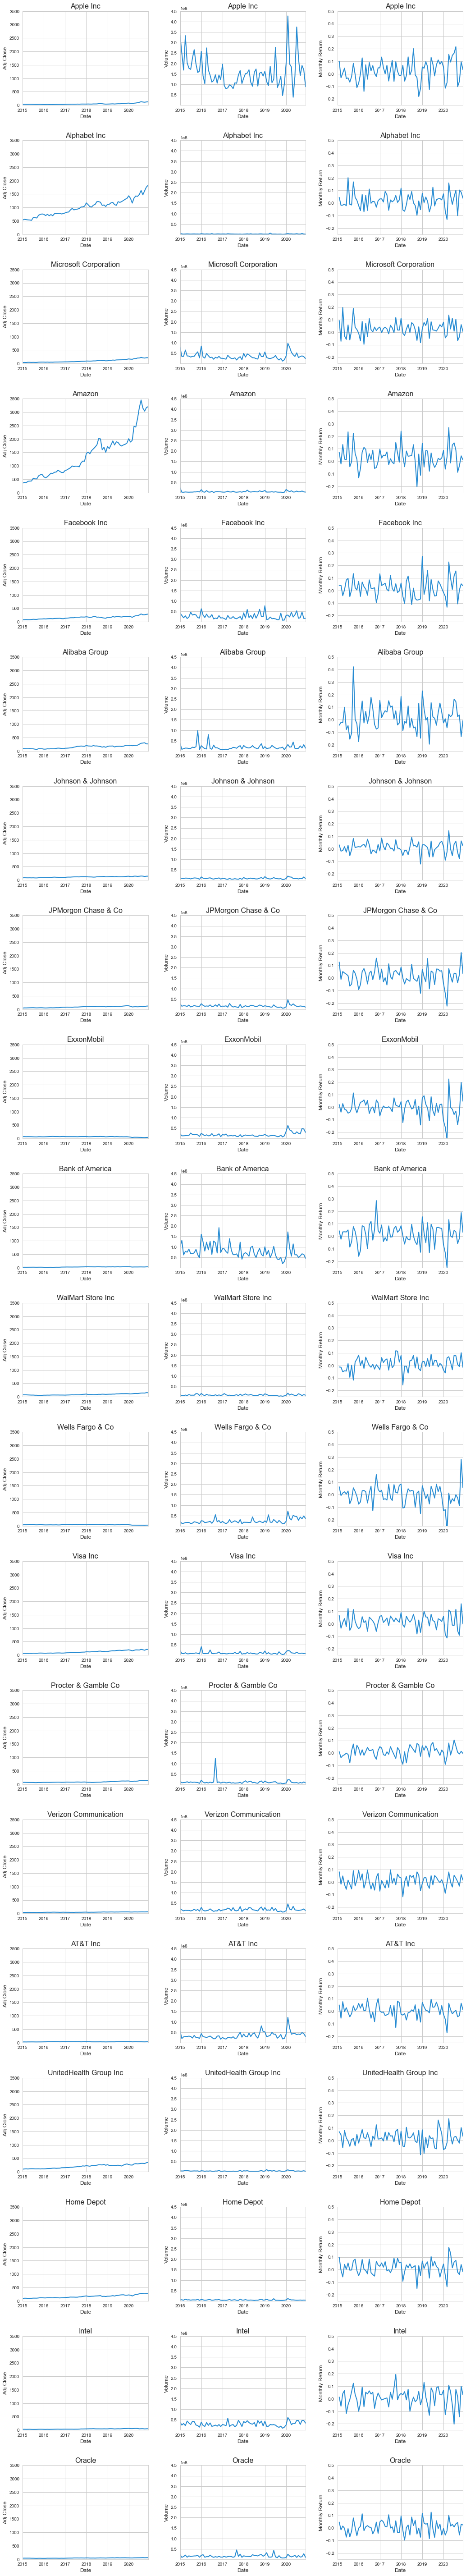

In [9]:
# here we are visualising of Monthly Adjusted Price, Monthly Volume and Monthly Return

fig, axes = plt.subplots(nrows = 20, ncols = 3)
#fig.suptitle('Monthly Adjusted Closing VS Monthly Volume VS Monthly Return')
fig.set_figheight(80)
fig.set_figwidth(15)
plt.subplots_adjust(bottom=0.1, right=1, top=0.9)

columns = list(monthly_adjusted_close) 
  
for i, cols in enumerate(columns,0):
    monthly_adjusted_close[cols].plot(ax = axes[i,0])
    title = CompanyNameMap[ticker_list[i]]
    axes[i,0].set(xlabel='Date', ylabel='Adj Close')
    axes[i,0].set_title(f"{title}")
    axes[i,0].set_ylim(0, 3500)
    monthly_volume[cols].plot(ax = axes[i,1])
    axes[i,1].set(xlabel='Date', ylabel='Volume')
    axes[i,1].set_title(f"{title}")
    axes[i,1].set_ylim(550000, 450000000)
    monthly_returns[cols].plot(ax = axes[i,2])
    axes[i,2].set(xlabel='Date', ylabel='Monthly Return')
    axes[i,2].set_title(f"{title}")
    axes[i,2].set_ylim(-0.25, 0.5)
    
fig.tight_layout(pad=3.0)

print(colored('\t\t\tMonthly Adjusted Closing VS Monthly Volume VS Monthly % Change', attrs=['bold']))


**In the above graph the first column figure shows monthly adjusted close price patterns, the second column graph shows the monthly volumes traded and the last column shows the monthly returns of each stock.**

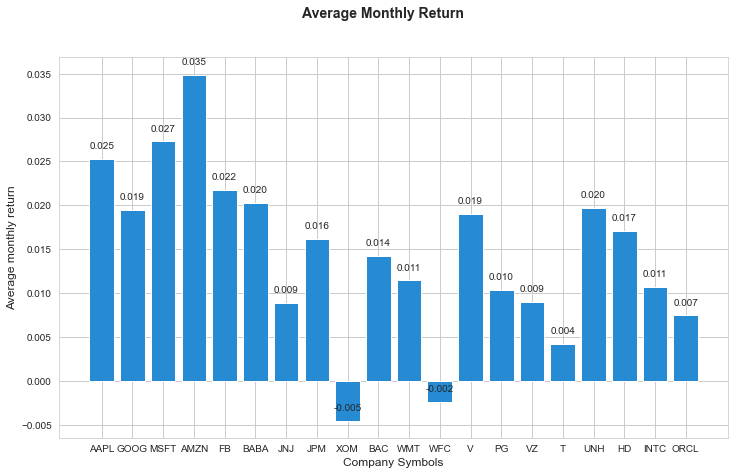

In [10]:
# Visualization of Average Monthly Return
plt.figure(figsize=(12, 7))
plt.bar(columns, monthly_returns.mean())

# zip joins x and y coordinate in pair
for x,y in zip(columns,monthly_returns.mean()):
    label = "{:.3f}".format(y)
    plt.annotate(label,(x,y),textcoords = 'offset points',xytext = (0,10),ha = 'center')

plt.xlabel('Company Symbols')
plt.ylabel('Average monthly return')
plt.suptitle('Average Monthly Return', fontweight = 'bold', fontsize = 14)
plt.show()

**What we can infer after looking at the average monthly return chart is that Amazon has the highest monthly average return with 3.5 percent, while ExxonMobil has the lowest monthly average return with -0.4 percent.**

**Let's filter the stocks down to top 5 with a higher monthly average return and look at the graph.**

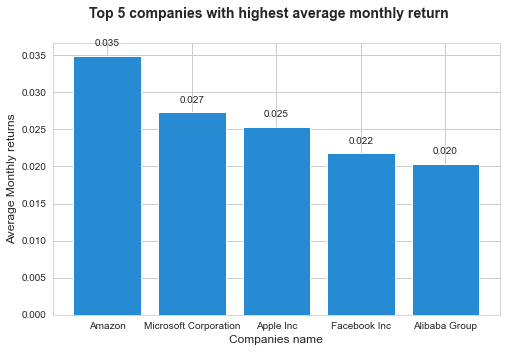

In [11]:
# Visualization of top five stock with highest monthly return
top_five = monthly_returns.mean().nlargest(5)

company_name = list(top_five.keys())
names = []
for key in company_name:
    names.append(CompanyNameMap[key])

plt.figure(figsize=(8, 5))
plt.bar(names, top_five)

# zip joins x and y coordinate in pair
for x,y in zip(names,top_five):
    label = "{:.3f}".format(y)
    plt.annotate(label,
                (x,y),
                textcoords = 'offset points',
                xytext = (0,10),
                ha = 'center')
plt.suptitle('Top 5 companies with highest average monthly return', fontsize = 14, fontweight = 'bold')
plt.ylabel('Average Monthly returns')
plt.xlabel('Companies name')
plt.show()

**Now that we've filtered the companies to top 5 on the basis of average monthly return and have seen the visualizations for the Adjusted price and the volume traded each day with monthly percentage change, let's go ahead and calculate the moving average for the stock.**

# 3. What was the moving average of the various stocks?

**We will be adding three major moving average intervals to our graphs in order to allow us to trade better. They are the moving averages of 10, 20 and 50 days.**

In [12]:
# Using loop for grabing yahoo data and setting it in form of dataframe
topFiveDataDict={}
for stock in company_name:
    topFiveDataDict[stock] = web.DataReader(stock,"yahoo",'2015-01-01',datetime.now())
    

In [13]:
#Here we are making pandas dataframe for top 5 company stocks
company_list = topFiveDataDict.values()
for company, comp_name in zip(company_list,company_name):
    company["company_name"] = comp_name
    
company_data = pd.concat(company_list,axis=0)
company_data.tail(5)


,High,Low,Open,Close,Volume,Adj Close,company_name
Date,,,,,,,
2020-11-25,279.329987,274.049988,275.700012,277.720001,15229300.0,277.720001,BABA
2020-11-27,278.920013,275.665985,278.799988,276.480011,9583200.0,276.480011,BABA
2020-11-30,268.970001,262.519989,268.970001,263.359985,30476100.0,263.359985,BABA
2020-12-01,265.670013,261.570007,265.470001,264.010010,14606300.0,264.010010,BABA
2020-12-02,263.100006,260.109985,262.000000,261.320007,13847300.0,261.320007,BABA


In [14]:
# Calculating the moving averages
ma_day = [10, 20, 50]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()

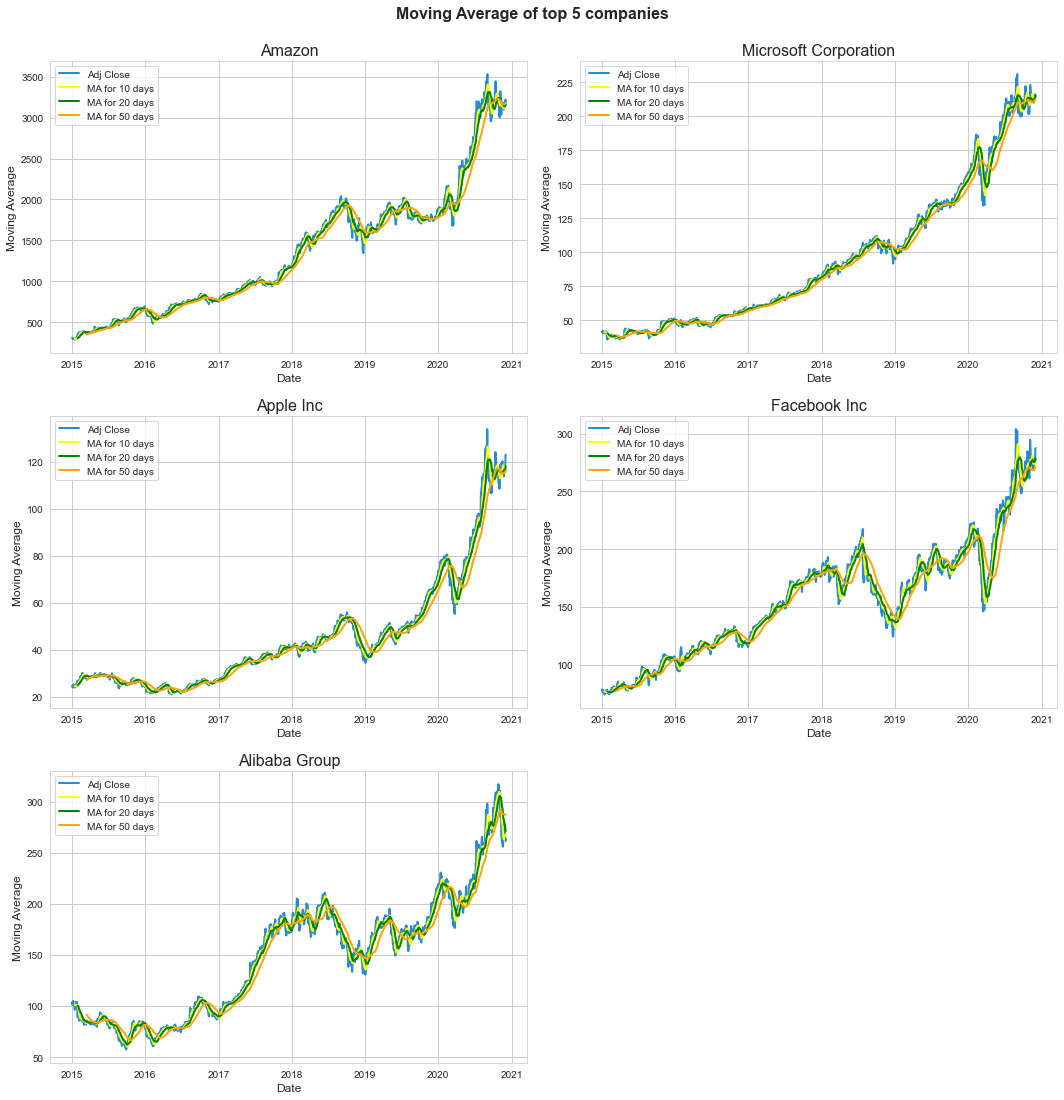

In [15]:
# here we are visualising three important moving averages of all the company
    
Total = 5
Columns = 2

# array of company datas
datas = list(topFiveDataDict.values())

# names of the company in array
names = list(topFiveDataDict.keys())

# Compute Rows required
Rows = Total // Columns 
Rows += Total % Columns

# Create a Position index
Position = range(1,Total + 1)
fig = plt.figure(1)
fig.set_figheight(15)
fig.set_figwidth(15)

for k in range(Total):
  # add every single subplot to the figure with a for loop
    ax = fig.add_subplot(Rows,Columns,Position[k])
    ax.plot(datas[k]['Adj Close'])
    ax.plot(datas[k]['MA for 10 days'], color = 'yellow')
    ax.plot(datas[k]['MA for 20 days'], color = 'green')
    ax.plot(datas[k]['MA for 50 days'], color = 'orange')
    ax.set_title(CompanyNameMap[names[k]])   
    ax.legend(['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days'])
    ax.set(xlabel='Date',ylabel='Moving Average')

fig.tight_layout(pad=1.5)
fig.suptitle('Moving Average of top 5 companies', fontsize = 16, fontweight = 'bold', y = 1.02)
plt.show()


From the above graph we can conclude that the average trend is identical to the patterns of its Adjusted Close Price regardless of any number of days. Microsoft seems to be the one that most of the time indicates the rising pattern, while Alibaba has the most fluctuating trends. 

# 4. What is the correlation between different stocks ?

In [16]:
# Getting Top five company Monthly Adjusted Close price
adjusted_close_five= monthly_adjusted_close[company_name]
adjusted_close_five.head()

Symbols,AMZN,MSFT,AAPL,FB,BABA
Date,,,,,
2015-01-31,354.529999,35.889252,26.465057,75.910004,89.080002
2015-02-28,380.160004,39.231266,29.132116,78.970001,85.120003
2015-03-31,372.100006,36.377277,28.218189,82.220001,83.239998
2015-04-30,421.779999,43.516735,28.381468,78.769997,81.290001
2015-05-31,429.230011,42.196693,29.668266,79.190002,89.320000


In [17]:
# here we are Making DataFrame which is Monthly % change
returns_five= adjusted_close_five.pct_change()
returns_five.tail()

Symbols,AMZN,MSFT,AAPL,FB,BABA
Date,,,,,
2020-08-31,0.090461,0.102752,0.216569,0.155832,0.143455
2020-09-30,-0.087579,-0.067397,-0.102526,-0.106753,0.024214
2020-10-31,-0.035754,-0.037370,-0.060012,0.004620,0.036431
2020-11-30,0.043440,0.060060,0.095493,0.052678,-0.135646
2020-12-31,0.011203,0.006073,0.033851,0.038091,-0.007746


Here we'll use joinplot to compare the monthly return of Amazon to itself and also between Amazon to Microsoft. Correlation between Amazon to itself should shows a perfectly linear relation.

	Correlation between Amazon with Amazon


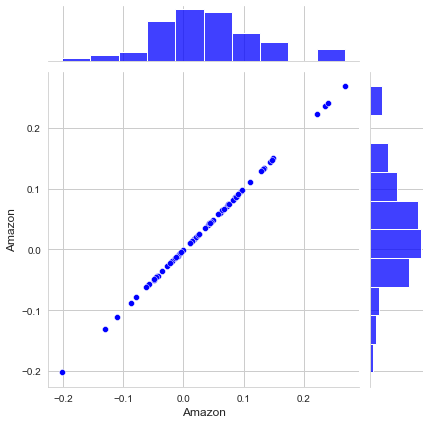

In [18]:
# Comparing Amazon to itself should show a perfectly linear relationship
fig = sns.jointplot('AMZN', 'AMZN', returns_five, kind='scatter', color = "blue")
fig.set_axis_labels('Amazon','Amazon')
;
print(colored('\tCorrelation between Amazon with Amazon', attrs=['bold']))

	Correlation between Amazon with Microsoft


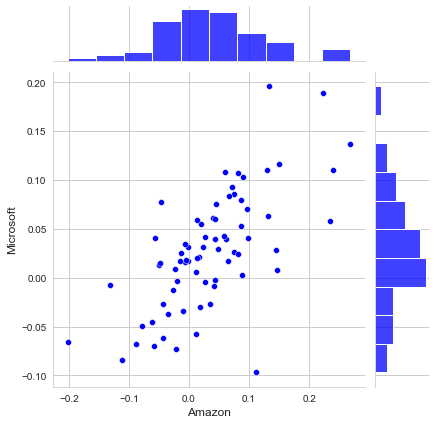

In [19]:
# Comparing monthly returns of Amazon and Microsoft
fig = sns.jointplot('AMZN', 'MSFT', returns_five, kind='scatter', color = "blue")
fig.set_axis_labels('Amazon','Microsoft')
;
print(colored('\tCorrelation between Amazon with Microsoft', attrs=['bold']))

We can see that if two stocks are perfectly (and positivley) correlated with each other a linear relationship between its monthly return values should occur. So now let see the relation between all the stock with each other.

In [20]:
# Renaming the columns 
fullname = []
for name in company_name:
    fullname.append(CompanyNameMap[name])

returns_five.columns = fullname


					Correlation between 5 companies


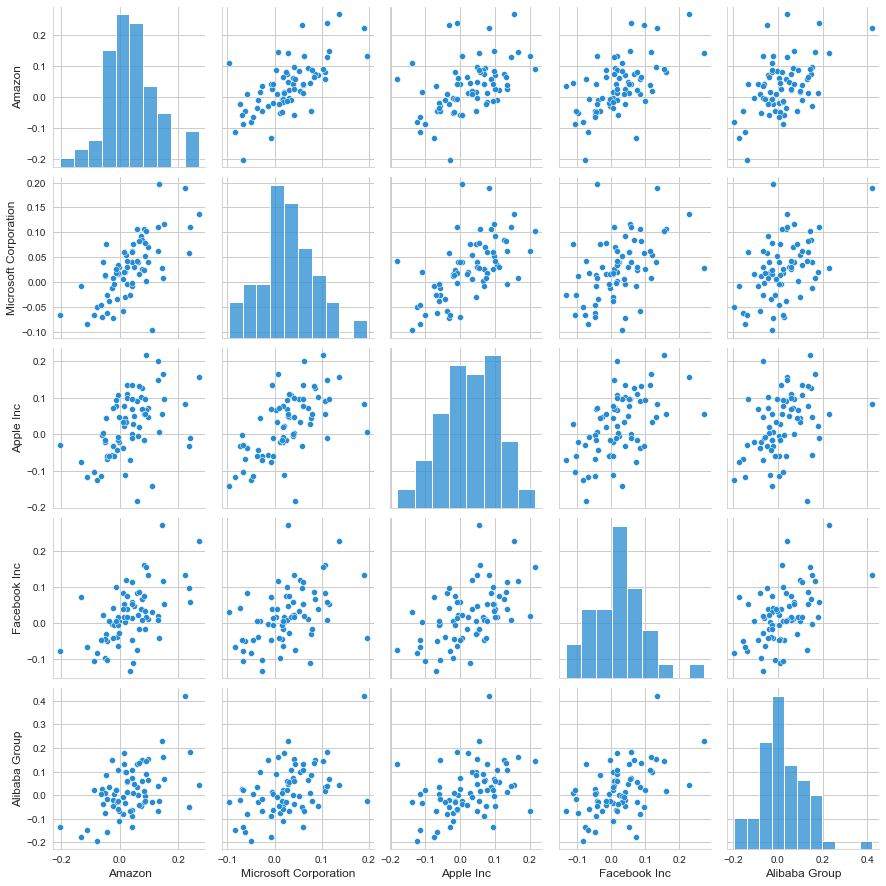

In [21]:
# Here we are calling pairplot on our DataFrame for an automatic visual analysis of all the comparisons
sns.pairplot(returns_five)
;
print(colored('\t\t\t\t\tCorrelation between 5 companies', attrs=['bold']))

It is interesting to see that all stocks are positively correlated and that Microsoft and Amazon had the highest monthly stock return correlation, while Alibaba and Apple were the least correlated. Let's see its meaning in numerical terms to understand this better.

''

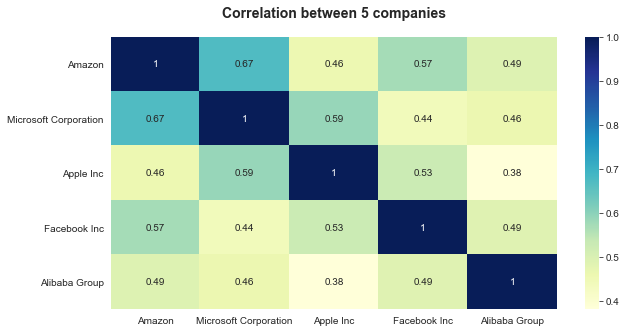

In [22]:
# Here we are using seaborn for a quick correlation plot for the monthly returns
plt.figure(figsize = (10,5))
sns.heatmap(returns_five.corr(), annot=True, cmap="YlGnBu")
plt.title('Correlation between 5 companies', fontsize = 14, fontweight = 'bold', y = 1.05)
;

# 5. How much value do we put at risk by investing in a particular stock?

It cannot be fruitful to invest in a stock that focuses only on higher returns, ignoring its risk factor. The best investment decision is known to be inventory with high return with low risk. So we'll look at the volatility of the stock from now on as well.

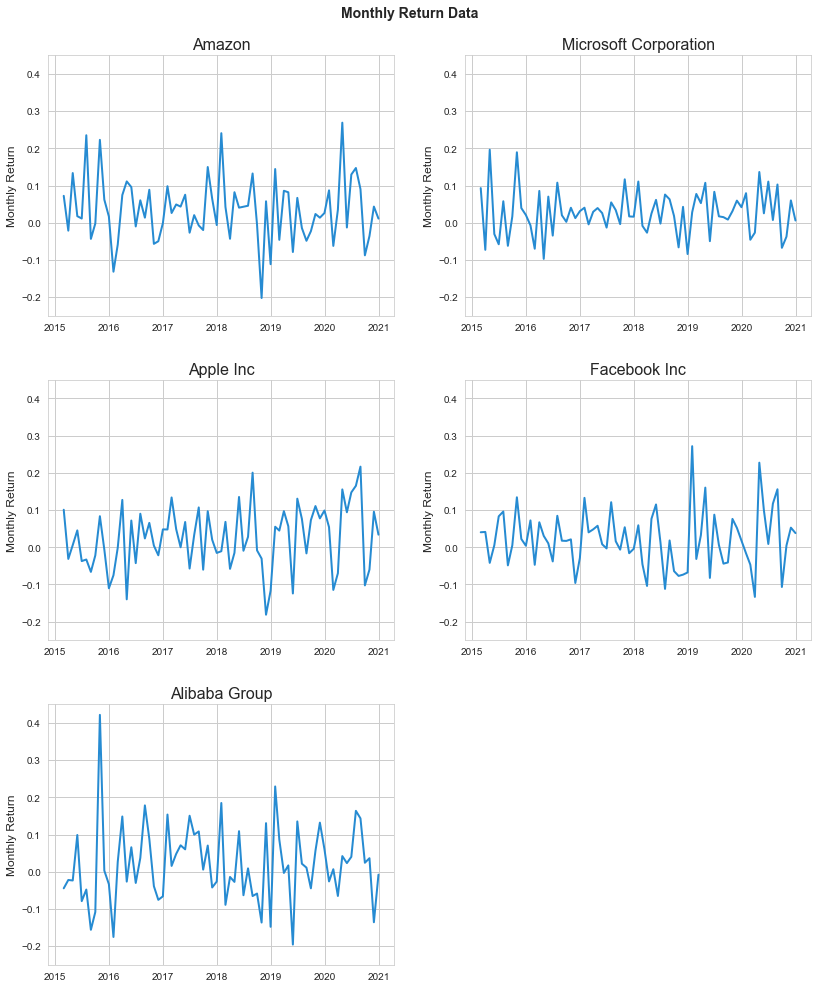

In [23]:
#Visualiation of Monthly Return percent

#Getting columns heading
columns = list(returns_five) 

plt.figure(figsize=(12, 15))

for i, col in enumerate(columns, 1):
    plt.subplot(3, 2, i)
    plt.plot(returns_five[col])
    plt.ylabel('Monthly Return')
    plt.title(f'{CompanyNameMap[names[i - 1]]}')
    plt.ylim(-0.25,0.45)
    
plt.suptitle('Monthly Return Data\n\n', fontweight = 'bold', fontsize = 14, y = 0.93)
plt.tight_layout(pad=3.0)

After looking at the monthly returns chart of each stock, we can conclude that the returns are quite volatile and the stock can move +0.5  to - 0.3% on any given month. To get a sense of how extreme the returns can be we can plot a histogram.

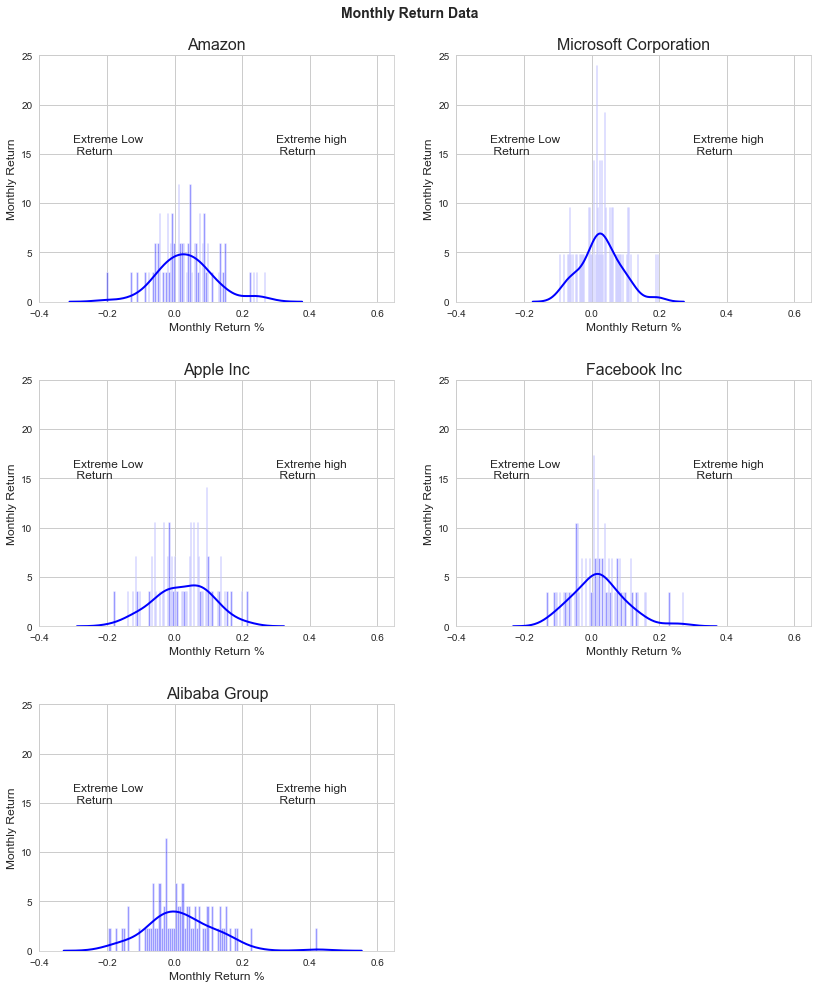

In [24]:
#Visualiation of Monthly Return percent
plt.figure(figsize=(12, 15))

for i, col in enumerate(columns, 1):
    plt.subplot(3, 2, i)
    sns.distplot(returns_five[col].dropna(), bins=100, color='blue')
    plt.ylabel('Monthly Return')
    plt.xlabel('Monthly Return %')
    plt.title(f'{CompanyNameMap[names[i - 1]]}')
    plt.ylim(0,25)
    plt.xlim(-0.4,0.65)
    plt.text(-0.3, 15, 'Extreme Low\n Return', fontsize = 12)
    plt.text(0.3, 15, 'Extreme high\n Return', fontsize = 12)
    
plt.suptitle('Monthly Return Data\n\n', fontweight = 'bold', fontsize = 14, y = 0.93)
plt.tight_layout(pad=3.0)

From above we can see that Microsoft's monthly return is least volatile and while Alibaba's is highly volatile.

Plotting monthly returns are useful for understanding the monthly volatility of the investment. To calculate the growth of our investment or in other word, calculating the total returns from our investment, we need to calculate the cumulative returns from that investment. To calculate the cumulative returns we will use the cumprod() function.

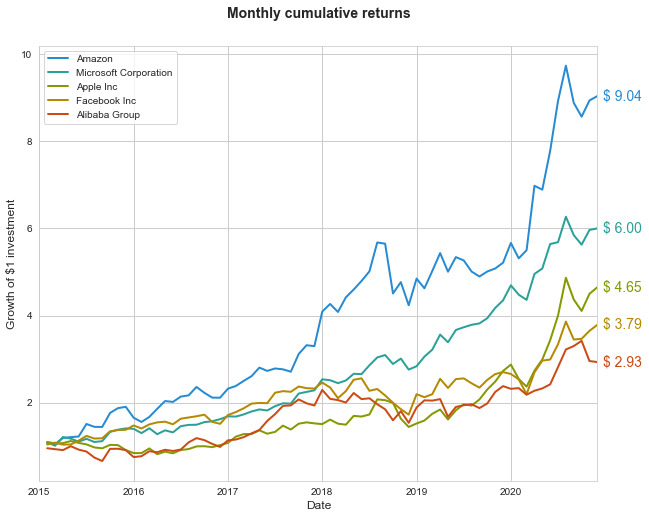

In [25]:
#Calculating the cumulative return
cum_returns = (returns_five + 1).cumprod()
values = cum_returns.tail(1).values[0]
values = map(lambda x : "$ {:.2f}".format(x), values)

#Visualizing the cumulative return of stock
ax = cum_returns.plot(figsize = (10,8))
ax.set_title("Monthly cumulative returns", fontsize = 14, fontweight = 'bold', y = 1.05)
ax.set_xlabel("Date")
ax.set_ylabel("Growth of $1 investment")
for line, name in zip(ax.lines, values):
    y = line.get_ydata()[-1]
    ax.annotate(name, xy=(1,y), xytext=(6,0), color=line.get_color(), 
                xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                size=14, va="center")

plt.show()

This chart displays the cumulative returns of each stock since 2015. It is showing how much one could have made today with an investment of $1 in 2015. Not surprisingly, from 2015, Amazon has had the highest returns. In the distant second and third, Microsoft and Apple come in. While its lowest earner is Alibaba.

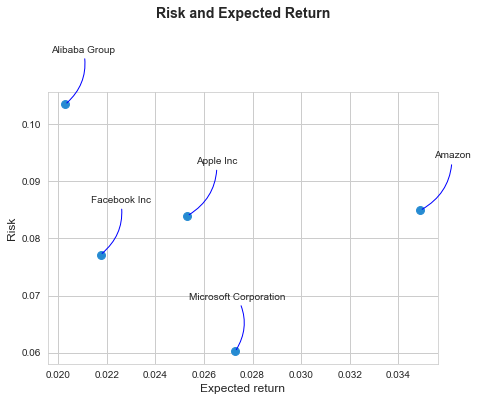

In [26]:
# Here we are defining a new DataFrame as a cleaned version of the original DataFrame
rets = returns_five.dropna()

area = np.pi*20

#Visualizing the cumulative return of stock
plt.figure(figsize=(7, 5))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')
plt.title('Risk and Expected Return',fontsize = 14, fontweight = 'bold', y = 1.25)

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

Above diagram shows the risk-return relationship of the best five high monthly return stock. It shows that Alibaba, Facebook and Apple Inc has high risk and low return compared to Microsoft and Amazon,  which clearly eliminate this stock on the proposed  investment decision. Amazon showing the highest return stock among them with 3.4% monthly return but considering the risk of 8.5% shows that the Amazon is good stock for investment for aggressive risk taker. As the conservative risk taker, Microsoft is the best stock with low level of risk of 6% to obtain the return of 2.8% is best stock to invest among these stock.

# 6. Portfoilo optimization using Efficient Frontier?

Here we are using the same top five stock with a higher return. We allocated equal weights of 20 percent to each of for the formation of the portfolio and measure the return and risk of investing in that portfolio. After that, using the minimum Sharpe ratio and minimum variance (risk or standard deviation), we determined the effective frontier portfolio.

In [27]:
# Getting Adjuested Close Price of five selected sock
adjusted_close = data['Adj Close'][company_name]

# Changing the columns name
adjusted_close.columns = fullname
adjusted_close.head()

,Amazon,Microsoft Corporation,Apple Inc,Facebook Inc,Alibaba Group
Date,,,,,
2015-01-02,308.519989,41.539135,24.696352,78.449997,103.599998
2015-01-05,302.190002,41.157158,24.000614,77.190002,101.000000
2015-01-06,295.290009,40.553074,24.002876,76.150002,103.320000
2015-01-07,298.420013,41.068310,24.339447,76.150002,102.129997
2015-01-08,300.459991,42.276463,25.274624,78.180000,105.029999


In [28]:
# Calculating the daily return
daily_return = adjusted_close.pct_change()
daily_return.head()

,Amazon,Microsoft Corporation,Apple Inc,Facebook Inc,Alibaba Group
Date,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN
2015-01-05,-0.020517,-0.009196,-0.028172,-0.016061,-0.025097
2015-01-06,-0.022833,-0.014677,0.000094,-0.013473,0.022970
2015-01-07,0.010600,0.012705,0.014022,0.000000,-0.011518
2015-01-08,0.006836,0.029418,0.038422,0.026658,0.028395


In [29]:
#Analysing of Annual portfiolo return and risk assuming 20% weight on each stock
#assuming trading days = 252 days in a year

weights = np.array([0.2,0.2,0.2,0.2,0.2])

# Calculating annual return of our portfolio
portfolio_return = np.sum(daily_return.mean()* weights)*252

# Calculation of covariance matrix
cov_matrix_annual = daily_return.cov()*252


''

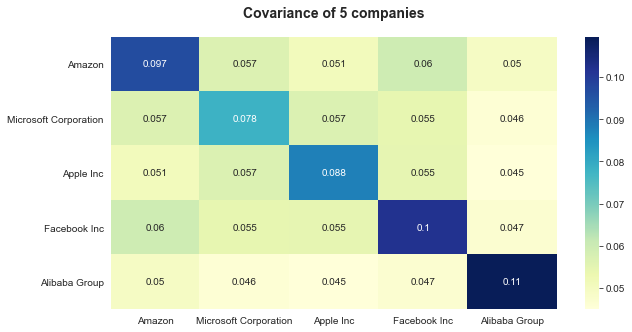

In [30]:
# Visualization of covariance matrix
plt.figure(figsize = (10,5))
sns.heatmap(cov_matrix_annual, annot=True, cmap="YlGnBu")
plt.title('Covariance of 5 companies', fontsize = 14, fontweight = 'bold', y = 1.05)
;

**From the above covariance matrix we can conclude that among the top five stocks, Alibabas companys stock has the highest volatility and combination of Alibaba and Appple has least volatility.**

In [31]:
# Calculating the volatility of our portfolio
portfolio_variance = np.dot(weights.T, np.dot(cov_matrix_annual,weights))
portfolio_std = np.sqrt(portfolio_variance)

# Assuming the value of risk free rate that already exist in market
risk_free_rate = 0.0178

# Calculation of sharpe ratio
# Sharpe ratio shows how much additional return an investor earns by taking additional risk
sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std

So, if we invest 20% of our total on each asset, then our portfolio will give:

In [32]:
print("Expected annual return: " + str(round((portfolio_return * 100),2))+'%')
print("Expected Volatility: " + str(round((portfolio_std * 100),2))+'%')
print("Sharpe Ratio: " + str(round((sharpe_ratio),2)))

Expected annual return: 31.19%
Expected Volatility: 24.65%
Sharpe Ratio: 1.19


We now know the projected return and volatility of our current portfolio. But what if we are not satisfied with our current portfolio's level of volatility and would like to reduce it? In pursuit of a higher expected return, what if we are willing to take on more risk? To achieve these objectives, how do we rearrange the weight of each stock in our portfolio? In this project, our main objective is to obtain an optimal portfolio. Two portfolios that we may like to highlight are
    
    1. The portfolio with the highest Sharpe Ratio (i.e. the highest risk adjusted returns) and 
    2. The "minimum variance portfolio," which is the lowest volatility portfolio

In [33]:
#calculate mean daily return and covariance of daily returns
mean_daily_returns = daily_return.mean()
cov_matrix = daily_return.cov()

#set number of runs of random portfolio weights
num_portfolios = 15000

In [34]:
# function that will calculate the annual return and volatility
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
# function that will generate portfolios with random weight
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(5)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

#Sharpe ratio describes how much excess return you are receiving for the extra volatility that you endure for holding a riskier asset. 
# function to calculate minimum sharpe ratio
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

#function to calculate maximum sharpe ratio
def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# function to calculate annual volatility
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

# function to calculate minimum variance
def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

# function that calculate the most efficient portfolio for a gieb target return
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)# Sequential Least Squares Programming (SLSQP).
    return result

# function that will take a range of target return ana compute efficient portfolio of each return level
def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

Let’s try to plot the portfolio choices with maximum Sharpe ratio and minimum volatility also with all the randomly generated portfolios. But this time, we are not picking the optimal ones from the randomly generated portfolios, but we are actually calculating by using Scipy’s ‘minimize’ function. And the below function will also plot the efficient frontier line.

In [35]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=adjusted_close.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=adjusted_close.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print(colored('Maximum Sharpe Ratio Portfolio Allocation\n', attrs=['bold']))
    print("Annualised Return:" + str(round(rp*100,2)) + "%")
    print("Annualised Volatility:" + str(round(sdp*100,2)) + "%")
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print(colored('Minimum Volatility Portfolio Allocation\n', attrs=['bold']))
    print("Annualised Return:" + str(round(rp_min * 100,2)) + "%")
    print("Annualised Volatility:" + str(round(sdp_min * 100,2)) + "%")
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
   

    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='RdYlBu', marker='o', s=25, alpha=0.3)
    plt.colorbar(label = 'Sharpe ratio')
    plt.scatter(sdp,rp,marker=(5,1,0),color='r',s=100, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker=(5,1,0),color='g',s=100, label='Minimum volatility')

    target = np.linspace(rp_min, 0.42, 30)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='--', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier', fontsize = 14, fontweight = 'bold', y = 1.05)
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return:40.67%
Annualised Volatility:27.69%


            Amazon  Microsoft Corporation  Apple Inc  Facebook Inc  \
allocation   70.78                  10.28      18.94           0.0   

            Alibaba Group  
allocation            0.0  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return:30.66%
Annualised Volatility:24.54%


            Amazon  Microsoft Corporation  Apple Inc  Facebook Inc  \
allocation   14.65                  27.85       22.5         13.62   

            Alibaba Group  
allocation          21.38  


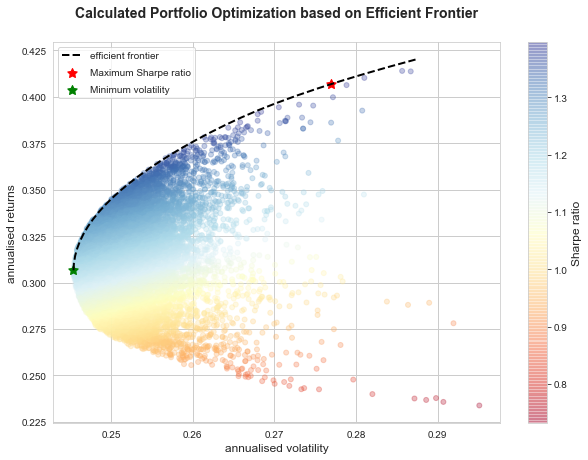

In [36]:
# Displaying the information and visualaizating of portfolios
display_calculated_ef_with_random(mean_daily_returns, cov_matrix, num_portfolios, risk_free_rate)

For the low risk portfolio, we can see that Microsoft and Apple are given a large budget. If you take another look at the monthly return plot from earlier, you can see that the least volatile stock of five is Microsoft and Apple, so it makes intuitive sense to assign a large percentage to Microsoft and then Apple for the minimum risk portfolio.

If we are able to take a higher risk for a higher return, the maximum Sharpe ratio is one that gives us the best risk-adjusted return. We allocate a large portion to Amazon in this situation, which are fairly volatile stocks from the previous monthly returns map. Microsoft and Apple, which had approximately 50 percent in the case of the low risk portfolio, have allocated the remaining budget to it. Leaving Facebook and Alibaba with 0% alloaction.

We can see that it forms the shape of an arch line on the top of clustered blue dots from the plot of the randomly simulated portfolios. This line is called the efficient frontier. Why is that efficient? Since points along the line will give you the lowest risk of return for a given target return. All the other dots on the line would give you higher risk with the same returns.

The way we found the two kinds of optimal portfolio above was by simulating many possible random choices and pick the best ones (either minimum risk or maximum risk-adjusted return).

Using the minimun volatility portfolio, if we have $10000, lets see much stock we can buy in todays price for the top 5 companies

In [37]:
# Calculating the expected returns and the annualised sample covariance matrix of asset returns
mu=expected_returns.mean_historical_return(adjusted_close)
S= risk_models.sample_cov(adjusted_close)

In [38]:
# For minimum volatility
ef=EfficientFrontier(mu,S)
weights=ef.min_volatility()
cleaned_weights=ef.clean_weights()
min_vol_port = ef.portfolio_performance(verbose=True)

Expected annual return: 30.0%
Annual volatility: 24.5%
Sharpe Ratio: 1.14


In [39]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(adjusted_close)
weights = cleaned_weights

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.lp_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Discrete allocation: {'Microsoft Corporation': 13, 'Apple Inc': 19, 'Facebook Inc': 5, 'Alibaba Group': 9}
Funds remaining: $1072.19


# 7. How can we attempt to predict future stock behavior using LSTM?

In [40]:
# Getting the data of only Microsoft
df = topFiveDataDict['MSFT']
df.tail()

,High,Low,Open,Close,Volume,Adj Close,company_name,MA for 10 days,MA for 20 days,MA for 50 days
Date,,,,,,,,,,
2020-11-25,215.289993,212.460007,215.110001,213.869995,21012900.0,213.869995,MSFT,213.311485,212.643260,211.292613
2020-11-27,216.270004,214.039993,214.850006,215.229996,14512200.0,215.229996,MSFT,213.346741,213.195489,211.549610
2020-11-30,214.759995,210.839996,214.100006,214.070007,33064800.0,214.070007,MSFT,213.159277,213.801923,211.833676
2020-12-01,217.320007,213.350006,214.509995,216.210007,30931300.0,216.210007,MSFT,213.114001,214.522340,212.117653
2020-12-02,215.470001,212.800003,214.880005,215.369995,23711600.0,215.369995,MSFT,213.261000,214.996292,212.287486


In [41]:
#Data cleaning
df.isna().any()
df = df.iloc[:,0:6]
df.isna().any()

High         False
Low          False
Open         False
Close        False
Volume       False
Adj Close    False
dtype: bool

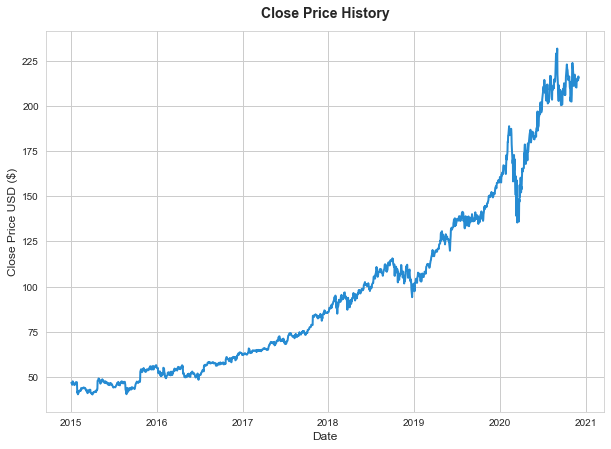

In [42]:
# here we are Visualising the closing price history
plt.figure(figsize=(10,7))
plt.title('Close Price History',fontsize = 14, fontweight = 'bold', y = 1.02)
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.show()

**From above graph we can see that microsofts closing price is in increasing trend**

In [43]:
# get close stock data
df1 = df[['Close']]
#reset index of data frame
df1.reset_index(inplace=True)
#converting date to pandas datetime format
df1['Date'] = pd.to_datetime(df1['Date'])

# Creating pivot table for monts
month_table = pd.pivot_table(df1,index=df1['Date'].dt.strftime('%b'),
               values=["Close"],
               aggfunc='mean',fill_value=0)

# Sorting by month
month = ['Jan', 'Feb', 'Mar', 'Apr','May','Jun', 'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec']
month_table.index = pd.CategoricalIndex(month_table.index, categories=month, ordered=True)
month_table = month_table.sort_index()


# Creating pivot table for weeks
weekdays_table = pd.pivot_table(df1,index=df1['Date'].dt.strftime('%a'),
               values=["Close"],
               aggfunc='mean',fill_value=0)

weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
weekdays_table.index = pd.CategoricalIndex(weekdays_table.index, categories=weekdays, ordered=True)
weekdays_table = weekdays_table.sort_index()


In [44]:
values = list(month_table['Close'].values)

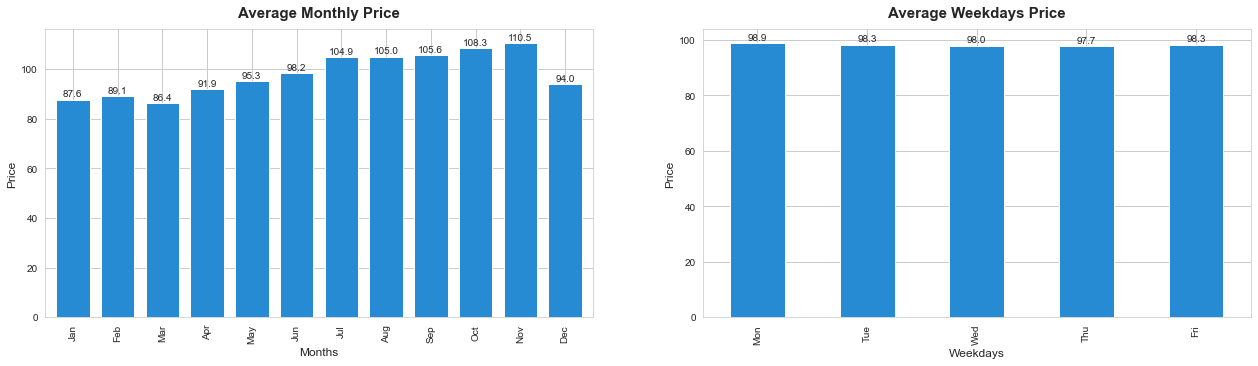

In [45]:
fig, ax = plt.subplots(1, 2,figsize=(10,5))

month_table.plot(kind = 'bar', ax = ax[0], width=0.75)
ax[0].set_title('Average Monthly Price', fontweight = 'bold', fontsize = 15, y = 1.02)
ax[0].set_xlabel('Months')
ax[0].set_ylabel('Price')
ax[0].get_legend().remove()

for rect in ax[0].patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        ax[0].annotate(label,                    
            (x_value, y_value),         
            xytext=(0, 3),         
            textcoords="offset points", 
            ha='center') 



weekdays_table.plot(kind = 'bar', ax = ax[1])
ax[1].set_title('Average Weekdays Price', fontweight = 'bold', fontsize = 15, y = 1.02)
ax[1].set_xlabel('Weekdays')
ax[1].set_ylabel('Price')
ax[1].get_legend().remove()

# Code for displaying values above bar
for rect in ax[1].patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        ax[1].annotate(label,                    
            (x_value, y_value),         
            xytext=(0, 3),         
            textcoords="offset points", 
            ha='center')              

plt.subplots_adjust(bottom=0.1, right=1.8, top=0.9)
plt.show()

From above weekly graph we can see that stock price is are tentatively similar through out the week days but is slighly higher in Monday.

If we look at monthly graph we can see that november is the month with the highest stock price.





Create a new data frame with only the closing price and convert it to an array. Then create a variable to store the length of the training data set. I want the training data set to contain about 80% of the data.

In [46]:
#Creating a new dataframe with only the 'Close' column
data = df.filter(['Close'])

#Converting the dataframe to a numpy array
dataset = data.values

#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8)


Now scale the data set to be values between 0 and 1 inclusive, I do this because it is generally good practice to scale your data before giving it to the neural network.

In [47]:
# Feature Scaling, Here we are Scaling the all of the data to be values between 0 and 1 using MinMax Scaler
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

Now we will create a data structure with 60 timestep and 1 output and then split the data into x_train and y_train data sets. Basically what we are trying to do here is take data from day 1 to 60 and make prediction of 61th days

In [48]:
#Creating the scaled training data set
train_data = scaled_data[0:training_data_len  , : ]

timestep = 60
x_train=[]
y_train = []

#Splitting data into x_train and y_train
for i in range(timestep,len(train_data)):
    x_train.append(train_data[i-timestep:i,0])
    y_train.append(train_data[i,0])
    
#Here we are Converting x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Here we are reshaping the data into the shape accepted by the LSTM
x_train_reshape = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [49]:
# Here we are testing data set and again repeat the same process that we did for x_train
test_data = scaled_data[training_data_len - timestep: , : ]

#Creating the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] # Here we fit the actual data that is lastest 30% data 

for i in range(timestep,len(test_data)):
    x_test.append(test_data[i-timestep:i,0])
    
# here we are converting x_test to a numpy array  
x_test = np.array(x_test)

# here we are reshaping the data into the shape accepted by the LSTM  
x_test_reshape = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [50]:
#Now we are Building the LSTM network model
# create model
model = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 128, return_sequences=True, activation='tanh', input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

#Adding the second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 64, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))

#Adding the third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 32, activation='tanh'))
model.add(Dropout(0.2))

# Addding the output layer
model.add(Dense(1))

In [51]:
# Compiling the model
model.compile(loss='mse', optimizer='adam')

In [52]:
# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 128)           66560     
_________________________________________________________________
dropout (Dropout)            (None, 60, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 64)            49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [ ]:
# Here we are training the model
val_dataset = tf.data.Dataset.from_tensor_slices((x_test_reshape, y_test)).batch(batch_size=64)
history = model.fit(
    x_train_reshape,
    y_train,
    epochs=100,
    batch_size=64,
    validation_data=val_dataset,
    use_multiprocessing=True
)

Epoch 1/100
18/18 [==============================] - 3s 143ms/step - loss: 0.0121 - val_loss: 33331.8320
Epoch 2/100
18/18 [==============================] - 1s 82ms/step - loss: 0.0015 - val_loss: 33337.7773
Epoch 3/100
18/18 [==============================] - 2s 86ms/step - loss: 9.6950e-04 - val_loss: 33333.4102
Epoch 4/100
18/18 [==============================] - 2s 117ms/step - loss: 8.8821e-04 - val_loss: 33334.8516
Epoch 5/100
18/18 [==============================] - 2s 95ms/step - loss: 8.1833e-04 - val_loss: 33328.8242
Epoch 6/100
18/18 [==============================] - 2s 97ms/step - loss: 8.3369e-04 - val_loss: 33325.8906
Epoch 7/100
18/18 [==============================] - 2s 121ms/step - loss: 8.1768e-04 - val_loss: 33342.7031
Epoch 8/100
18/18 [==============================] - 2s 109ms/step - loss: 8.2738e-04 - val_loss: 33336.4180
Epoch 9/100
18/18 [==============================] - 2s 121ms/step - loss: 7.5858e-04 - val_loss: 33336.8438
Epoch 10/100
18/18 [===========

Epoch 76/100
18/18 [==============================] - 2s 103ms/step - loss: 3.7362e-04 - val_loss: 33327.3438
Epoch 77/100
18/18 [==============================] - 2s 104ms/step - loss: 3.6537e-04 - val_loss: 33334.9023
Epoch 78/100
18/18 [==============================] - 2s 94ms/step - loss: 3.9174e-04 - val_loss: 33331.8125
Epoch 79/100
18/18 [==============================] - 2s 105ms/step - loss: 3.8437e-04 - val_loss: 33333.4297
Epoch 80/100
18/18 [==============================] - 2s 88ms/step - loss: 3.9070e-04 - val_loss: 33324.7266
Epoch 81/100
18/18 [==============================] - 2s 99ms/step - loss: 3.6828e-04 - val_loss: 33327.1055
Epoch 82/100
18/18 [==============================] - 2s 115ms/step - loss: 3.8077e-04 - val_loss: 33326.0977
Epoch 83/100
18/18 [==============================] - 2s 113ms/step - loss: 4.4044e-04 - val_loss: 33334.8438
Epoch 84/100
18/18 [==============================] - 2s 133ms/step - loss: 3.5162e-04 - val_loss: 33334.9062
Epoch 85/100


In [ ]:
# now we are getting the models predicted price values
predictions = model.predict(x_test_reshape)

predictions = scaler.inverse_transform(predictions)#Undo scaling

In [ ]:
#Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Table of predicted and actual price
valid.tail()

In [ ]:
#Visualize the data
plt.figure(figsize=(15,7))
plt.title('Model generated price prediction',fontsize = 14, fontweight = 'bold', y = 1.02)
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'])
plt.plot(valid['Close'], color = 'green')
plt.plot(valid['Predictions'], color = 'orange')
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Predicted Price vs Actual Price',fontsize = 14, fontweight = 'bold', y = 1.02)
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(valid['Close'], color = 'green')
plt.plot(valid['Predictions'], color = 'orange')
plt.legend(['Actual Price', 'Predictions Price'], loc='lower right')
plt.show()
;

print('Mean Absolute Error: {:.3f}'.format(metrics.mean_absolute_error(y_test,predictions)))
print('Mean Square Error: {:.3f}'.format(metrics.mean_squared_error(y_test,predictions)))
print('Root Mean Square Error: {:.3f}'.format(math.sqrt(metrics.mean_squared_error(y_test,predictions))))

What we can infer from the above graph is that our model does the fine job of predicting the stock price as the real price and the expected price are very similar with just 6.46 percent of the mean absolute error 

As we have already developed our model using LSTM for stock price prediction. Now, what we are planning to try is to forecast stock prices for the next 30 days.

In [ ]:
# Taking previous 60 data in order to predict future stock price
x_input = test_data[len(test_data)-timestep:].reshape(1,-1)

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [ ]:
# demonstrate prediction for next 30 days

lst_output=[] # list to store the 30 days predicted price
n_steps = 60
i = 0
while(i < 30):
    
    if(len(temp_input) > 60):
        x_input=np.array(temp_input[1:])
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input) # predicting the price
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input) # predicting the price
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1
    

In [ ]:
future_predictions = scaler.inverse_transform(lst_output)#Undo scaling

In [ ]:
import datetime

lst_date = [] # list to that store next 30 days
day = datetime.datetime.today() # today date

# Getting next 30 days
for i in range(30):
    day = day + datetime.timedelta(days=1)
    nextDay = day.strftime ('%Y-%m-%d') # format the date to ddmmyyyy
    lst_date.append(nextDay)

In [ ]:
# Getting todays date
today = datetime.datetime.today().strftime ('%Y-%m-%d')

# Getting today price of stock
today_price = df['Close'].tail(1).values

# Creating dataframe today stock price
today_df = pd.DataFrame({'Date': today, 'Price':today_price})

In [ ]:
# Adding the predicted stock price to dataframe
pred_df = pd.DataFrame({'Date':lst_date})

pred_df['Price'] = future_predictions

pred_df = pd.concat([today_df,pred_df])

pred_df['Date'] = pd.to_datetime(pred_df['Date'])

pred_df = pred_df.set_index('Date')

# Looking at the head of predicted price
pred_df.head()


In [ ]:
#Visualize the price data
plt.figure(figsize=(16,8))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df['Close'].tail(150))
plt.plot(pred_df)
plt.legend(['Past Price', 'Future Price'], loc='upper left')
plt.show()

Thus, our model prediction shows that the stock price will be in increasing trend for the next 30 days. 

# Conclusion

Outline of what we did in this project
- Took 20 companies stock data since 2015 from yahoo finance
- Filtered 20 companies to top 5 on the basis of monthly return on investment
- Made optional portfolio of top 5 companies using [efficient frontier](https://www.investopedia.com/terms/e/efficientfrontier.asp#:~:text=The%20efficient%20frontier%20is%20the,for%20the%20level%20of%20risk.)
- Selected one company among the top 5 on the basis of minimum risk and maximun return
- Used LSTM Neural Network model to predict the price of stock for next 30 days